# Setup

In [ ]:
!pip install -q fasttext-langdetect

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 1.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.


In [ ]:
import bs4
import datasets
import gzip
import json
import ftlangdetect
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import requests
import string

# Data Loading

In [ ]:
url = "https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/goodreads/goodreads_books.json.gz"
with requests.get(url, stream=True) as response:
    response.raise_for_status()

    with open("books.json.gz", "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

In [ ]:
with gzip.open("books.json.gz") as file:
    item = json.loads(file.readline())
    for key, value in item.items():
        print(key, value, sep=": ")

isbn: 0312853122
text_reviews_count: 1
series: []
country_code: US
language_code: 
popular_shelves: [{'count': '3', 'name': 'to-read'}, {'count': '1', 'name': 'p'}, {'count': '1', 'name': 'collection'}, {'count': '1', 'name': 'w-c-fields'}, {'count': '1', 'name': 'biography'}]
asin: 
is_ebook: false
average_rating: 4.00
kindle_asin: 
similar_books: []
description: 
format: Paperback
link: https://www.goodreads.com/book/show/5333265-w-c-fields
authors: [{'author_id': '604031', 'role': ''}]
publisher: St. Martin's Press
num_pages: 256
publication_day: 1
isbn13: 9780312853129
publication_month: 9
edition_information: 
publication_year: 1984
url: https://www.goodreads.com/book/show/5333265-w-c-fields
image_url: https://images.gr-assets.com/books/1310220028m/5333265.jpg
book_id: 5333265
ratings_count: 3
work_id: 5400751
title: W.C. Fields: A Life on Film
title_without_series: W.C. Fields: A Life on Film


In [ ]:
def parse_book(line):
    book = json.loads(line)
    return {
        "title": book["title"],
        "description": book["description"],
        "language": book["language_code"],
    }

with gzip.open("books.json.gz") as file:
    books = [parse_book(line) for line in file]

In [ ]:
len(books)

2360655

# Preprocessing

In [ ]:
df = pd.DataFrame.from_records(books)

df

,title,description,language
0,W.C. Fields: A Life on Film,,
1,Good Harbor,"Anita Diamant's international bestseller ""The ...",
2,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",Omnibus book club edition containing the Ladie...,eng
3,Best Friends Forever,Addie Downs and Valerie Adler were eight when ...,eng
4,Runic Astrology: Starcraft and Timekeeping in ...,,
...,...,...,...
2360650,"This Sceptred Isle, Vol. 10: The Age of Victor...","The award-winning story of Britain, from the a...",eng
2360651,Sherlock Holmes and the July Crisis,Sir Arthur Conan Doyle is brought back to life...,eng
2360652,The Children's Classic Poetry Collection,"Gathers poems by William Blake, Emily Bronte, ...",
2360653,"101 Nights: Volume One (101 Nights, #1-3)","Volume One contains: ""Claimed,"" ""Tainted,"" and...",eng


## Drop Empty Text

In [ ]:
for column in df.columns:
    df[column] = df[column].replace("", np.nan)

df.head()

,title,description,language
0,W.C. Fields: A Life on Film,NaN,NaN
1,Good Harbor,"Anita Diamant's international bestseller ""The ...",NaN
2,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",Omnibus book club edition containing the Ladie...,eng
3,Best Friends Forever,Addie Downs and Valerie Adler were eight when ...,eng
4,Runic Astrology: Starcraft and Timekeeping in ...,NaN,NaN


In [ ]:
df.isna().sum()

title                7
description     412233
language       1060153
dtype: int64

In [ ]:
df.dropna(subset=["title", "description"], inplace=True)

df

,title,description,language
1,Good Harbor,"Anita Diamant's international bestseller ""The ...",NaN
2,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",Omnibus book club edition containing the Ladie...,eng
3,Best Friends Forever,Addie Downs and Valerie Adler were eight when ...,eng
5,The Aeneid for Boys and Girls,"Relates in vigorous prose the tale of Aeneas, ...",NaN
7,All's Fairy in Love and War (Avalon: Web of Ma...,"To Kara's astonishment, she discovers that a p...",NaN
...,...,...,...
2360649,Herança,Brigitte e feliz. Tem um trabalho de que gosta...,por
2360650,"This Sceptred Isle, Vol. 10: The Age of Victor...","The award-winning story of Britain, from the a...",eng
2360651,Sherlock Holmes and the July Crisis,Sir Arthur Conan Doyle is brought back to life...,eng
2360652,The Children's Classic Poetry Collection,"Gathers poems by William Blake, Emily Bronte, ...",NaN


## Drop Duplicates

In [ ]:
df["description"].duplicated().sum()

274377

In [ ]:
df.drop_duplicates(subset="description", inplace=True)

df

,title,description,language
1,Good Harbor,"Anita Diamant's international bestseller ""The ...",NaN
2,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",Omnibus book club edition containing the Ladie...,eng
3,Best Friends Forever,Addie Downs and Valerie Adler were eight when ...,eng
5,The Aeneid for Boys and Girls,"Relates in vigorous prose the tale of Aeneas, ...",NaN
7,All's Fairy in Love and War (Avalon: Web of Ma...,"To Kara's astonishment, she discovers that a p...",NaN
...,...,...,...
2360649,Herança,Brigitte e feliz. Tem um trabalho de que gosta...,por
2360650,"This Sceptred Isle, Vol. 10: The Age of Victor...","The award-winning story of Britain, from the a...",eng
2360651,Sherlock Holmes and the July Crisis,Sir Arthur Conan Doyle is brought back to life...,eng
2360652,The Children's Classic Poetry Collection,"Gathers poems by William Blake, Emily Bronte, ...",NaN


In [ ]:
df["title"].duplicated().sum()

319053

In [ ]:
df.drop_duplicates(subset="title", inplace=True)

df

,title,description,language
1,Good Harbor,"Anita Diamant's international bestseller ""The ...",NaN
2,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",Omnibus book club edition containing the Ladie...,eng
3,Best Friends Forever,Addie Downs and Valerie Adler were eight when ...,eng
5,The Aeneid for Boys and Girls,"Relates in vigorous prose the tale of Aeneas, ...",NaN
7,All's Fairy in Love and War (Avalon: Web of Ma...,"To Kara's astonishment, she discovers that a p...",NaN
...,...,...,...
2360648,Different Breeds,Derek and Blake have an understanding -- they ...,eng
2360650,"This Sceptred Isle, Vol. 10: The Age of Victor...","The award-winning story of Britain, from the a...",eng
2360651,Sherlock Holmes and the July Crisis,Sir Arthur Conan Doyle is brought back to life...,eng
2360652,The Children's Classic Poetry Collection,"Gathers poems by William Blake, Emily Bronte, ...",NaN


## Drop Non-English Text

In [ ]:
df["language"].value_counts()

language
eng      408514
en-US     52082
spa       36207
ita       35578
en-GB     34472
          ...  
grn           1
en-IN         1
tup           1
jrb           1
lao           1
Name: count, Length: 189, dtype: int64

In [ ]:
df["language"] = df["language"].replace(
    r"(eng|en-[A-Z]+)",
    "en",
    regex=True,
)

df["language"].value_counts()

language
en     500006
spa     36207
ita     35578
ara     24283
fre     22389
        ...  
nah         1
chb         1
tup         1
jrb         1
lao         1
Name: count, Length: 184, dtype: int64

In [ ]:
df[df["language"].isna()]

,title,description,language
1,Good Harbor,"Anita Diamant's international bestseller ""The ...",NaN
5,The Aeneid for Boys and Girls,"Relates in vigorous prose the tale of Aeneas, ...",NaN
7,All's Fairy in Love and War (Avalon: Web of Ma...,"To Kara's astonishment, she discovers that a p...",NaN
8,Playmaker: A Venom Series Novella,Secrets. Sometimes keeping them in confidence ...,NaN
9,The Devil's Notebook,"Wisdom, humor, and dark observations by the fo...",NaN
...,...,...,...
2360632,The Sensible Necktie and Other Stories of Sher...,From the author of The Cotswolds Werewolf come...,NaN
2360638,Waking Up in Charleston,The moment Amanda defied her rich and powerful...,NaN
2360644,North Country Cutthroats (The Trailsman #314),Skye Fargo gets an early Christmas present whe...,NaN
2360647,The Spaniard's Blackmailed Bride,"Blackmailed into marriage to save her family, ...",NaN


In [ ]:
df = df[(df["language"] == "en") | df["language"].isna()].copy()

df

,title,description,language
1,Good Harbor,"Anita Diamant's international bestseller ""The ...",NaN
2,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",Omnibus book club edition containing the Ladie...,en
3,Best Friends Forever,Addie Downs and Valerie Adler were eight when ...,en
5,The Aeneid for Boys and Girls,"Relates in vigorous prose the tale of Aeneas, ...",NaN
7,All's Fairy in Love and War (Avalon: Web of Ma...,"To Kara's astonishment, she discovers that a p...",NaN
...,...,...,...
2360648,Different Breeds,Derek and Blake have an understanding -- they ...,en
2360650,"This Sceptred Isle, Vol. 10: The Age of Victor...","The award-winning story of Britain, from the a...",en
2360651,Sherlock Holmes and the July Crisis,Sir Arthur Conan Doyle is brought back to life...,en
2360652,The Children's Classic Poetry Collection,"Gathers poems by William Blake, Emily Bronte, ...",NaN


## Detect Unknown Languages

In [ ]:
def is_nan(value):
    return isinstance(value, float) and np.isnan(value)

for i, row in df.iterrows():
    if not is_nan(row["language"]):
        continue

    # FastText can't handle newlines.
    description = row["description"].replace("\n", " ").strip()
    df.at[i, "language"] = ftlangdetect.detect(description)["lang"]

In [ ]:
df["language"].value_counts()

language
en    1031681
es       5734
fr       3110
de       2140
id       1129
       ...   
bg          1
mt          1
km          1
my          1
sw          1
Name: count, Length: 79, dtype: int64

In [ ]:
df = df[df["language"] == "en"].copy()

df

,title,description,language
1,Good Harbor,"Anita Diamant's international bestseller ""The ...",en
2,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",Omnibus book club edition containing the Ladie...,en
3,Best Friends Forever,Addie Downs and Valerie Adler were eight when ...,en
5,The Aeneid for Boys and Girls,"Relates in vigorous prose the tale of Aeneas, ...",en
7,All's Fairy in Love and War (Avalon: Web of Ma...,"To Kara's astonishment, she discovers that a p...",en
...,...,...,...
2360648,Different Breeds,Derek and Blake have an understanding -- they ...,en
2360650,"This Sceptred Isle, Vol. 10: The Age of Victor...","The award-winning story of Britain, from the a...",en
2360651,Sherlock Holmes and the July Crisis,Sir Arthur Conan Doyle is brought back to life...,en
2360652,The Children's Classic Poetry Collection,"Gathers poems by William Blake, Emily Bronte, ...",en


## Drop Gibberish Text

In [ ]:
nltk.download("words")
nltk.download("wordnet")

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
punctuation_remover = str.maketrans("", "", string.punctuation)

def clean_text(text):
    text = bs4.BeautifulSoup(text, "html.parser").get_text()
    text = text.lower()
    text = text.translate(punctuation_remover)
    return text

In [ ]:
clean_text("She has a 2,000 USD phone! <strong>Why?</strong>")

'she has a 2000 usd phone why'

In [ ]:
tokenizer = nltk.WordPunctTokenizer()
lemmatizer = nltk.WordNetLemmatizer()
vocabulary = set(nltk.corpus.words.words())

def word_percentage(text):
    text = clean_text(text)
    tokens = tokenizer.tokenize(text)

    if len(tokens) == 0:
        return 0

    count = sum(lemmatizer.lemmatize(token) in vocabulary for token in tokens)
    return count / len(tokens)

In [ ]:
word_percentage("She has a 2,000 USD phone! <strong>Why?</strong")

0.5714285714285714

In [ ]:
df["description_word_percentage"] = df["description"].apply(word_percentage)

df.head()

<ipython-input-24-e1354ee5953a>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = bs4.BeautifulSoup(text, "html.parser").get_text()
<ipython-input-24-e1354ee5953a>:4: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = bs4.BeautifulSoup(text, "html.parser").get_text()


,title,description,language,description_word_percentage
1,Good Harbor,"Anita Diamant's international bestseller ""The ...",en,0.868545
2,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",Omnibus book club edition containing the Ladie...,en,0.785714
3,Best Friends Forever,Addie Downs and Valerie Adler were eight when ...,en,0.894231
5,The Aeneid for Boys and Girls,"Relates in vigorous prose the tale of Aeneas, ...",en,0.800000
7,All's Fairy in Love and War (Avalon: Web of Ma...,"To Kara's astonishment, she discovers that a p...",en,0.894410


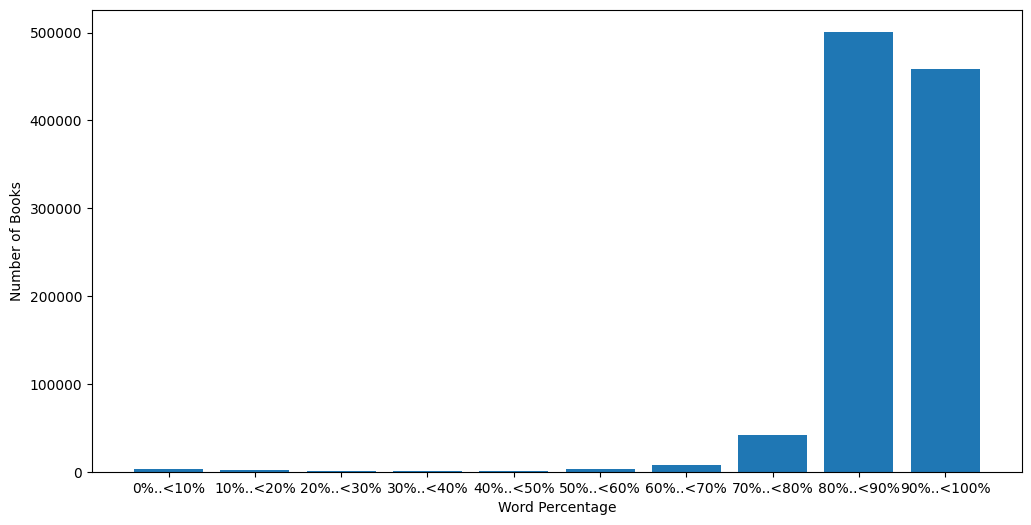

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(
    x=[
        f"{i}%..<{i + 10}%"
        for i in range(0, 100, 10)
    ],
    height=[
        sum(i <= x < i + 0.1 for x in df["description_word_percentage"])
        for i in np.arange(0, 1, 0.1)
    ],
)
plt.xlabel("Word Percentage")
plt.ylabel("Number of Books")
plt.show()

In [ ]:
threshold = 0.6
likely_gibberish = df[df["description_word_percentage"] < threshold]
likely_gibberish = likely_gibberish.sort_values(by="description_word_percentage")

In [ ]:
for description in likely_gibberish["description"].head(25):
    print(description.replace("\n", "\\n"))
    print()

eruue`ngraawkh`ng maataaldaahyingsaawaesnchuue` m`ngolkainaengdii aelahlaaykhnkhidwaaeth`ephiiyn\nkabekhaa...khunhm`purim phuuthiisangkhmm`ngwaaaesnephiiybphr`m thangthiikhwaamcchringaelw ekhaa`aacchkhaadmaakkwaaaikhrhlaay+khn\neth`aelaekhaa cchuengnabaidwaa taangkhntaangekhaamaaetimetmhawaicchaihkan\nthukkhnm`ngwaaeth`epnphuuhyingaeplkphiluek thiinaasngsaar aelaekhaaepnphuuchaaysmbuurnaebbthiinaarisyaa sangkhmmanebiiywhruue`khnphwkniikhwaamkhidtuuenekhin thuengaidm`ngthuk`yaangklabdaan ekhaataanghaakthiinaasngsaar eth`taanghaakthiinaarisyaa

ASIN: B000PGFR3Y

shrH mbsT wtwDyH lTyf bTryq@ t`lymy@ mbsT@ wb'slwb mdrsy m`Sr lmtn ysGwjy fy `lm lmnTq

ark:/13960/t9960n87z

RRRRrrrRAAAAHHHGHGGGG! Errf errrf errff AAAAANNNNG! GGGGGNNNNNaAaAaAaAaA!

khwaamsamphantht`nghaam!\nrahwaang 'phiikh`ngephuue`n' kab 'ephuue`nkh`ngn`ng'\nraach...thaayaathkhnr`ng hnumkal`nswmmaadnakthurkicch\nekhaatangkdchiiwitaids`ngkh` khuue` 'aimaetngngaan' aela 'aimyungkabephuue`nn`ngsaaw'\naelwwanhnuengkhwaamtangaic

In [ ]:
for description in likely_gibberish["description"].tail(25):
    print(description.replace("\n", "\\n"))
    print()

"Game Art" is a collection of breathtaking art from 40 video games and interviews with their creators. Featuring major studios like Square Enix, Bioware, and Ubisoft as well as independents like Tale of Tales and E-Line Media, Game Art explores and celebrates the creative process that turns a video game into art.\nArt from: Akaneiro: Demon Hunters Alice: Madness Returns American McGee's Alice Atelier Escha & Logy Atelier Meruru Atelier Rorona Atelier Shallie Atelier Totori Bientot l'ete Bladestorm: Nightmare Child of Light Contrast D4: Dark Dreams Don't Die Dead or Alive 5 Deception IV Dragon Age: Inquisition Dynasty Warriors escapeVektor Fairy Fencer F Fatal Frame II Final Fantasy XIV: A Realm Reborn flowmo Gamebook Adventures The Graveyard Hyperdimension Neptunia KILLER IS DEAD LOLLIPOP CHAINSAW Luxuria Superbia Malevolence: The Sword of Ahkranox Monster Monpiece NaissanceE Never Alone Ninja Gaiden 3 The Path Samurai Warriors Shadows of the DAMNED Sorcery Saga: Curse of the Great Cur

In [ ]:
df = df[df["description_word_percentage"] >= threshold].copy()

df

,title,description,language,description_word_percentage
1,Good Harbor,"Anita Diamant's international bestseller ""The ...",en,0.868545
2,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",Omnibus book club edition containing the Ladie...,en,0.785714
3,Best Friends Forever,Addie Downs and Valerie Adler were eight when ...,en,0.894231
5,The Aeneid for Boys and Girls,"Relates in vigorous prose the tale of Aeneas, ...",en,0.800000
7,All's Fairy in Love and War (Avalon: Web of Ma...,"To Kara's astonishment, she discovers that a p...",en,0.894410
...,...,...,...,...
2360647,The Spaniard's Blackmailed Bride,"Blackmailed into marriage to save her family, ...",en,0.852941
2360648,Different Breeds,Derek and Blake have an understanding -- they ...,en,0.901235
2360650,"This Sceptred Isle, Vol. 10: The Age of Victor...","The award-winning story of Britain, from the a...",en,0.767742
2360651,Sherlock Holmes and the July Crisis,Sir Arthur Conan Doyle is brought back to life...,en,0.824324


# Push  to Huggingface

In [ ]:
df.head()

,title,description,language,description_word_percentage
1,Good Harbor,"Anita Diamant's international bestseller ""The ...",en,0.868545
2,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",Omnibus book club edition containing the Ladie...,en,0.785714
3,Best Friends Forever,Addie Downs and Valerie Adler were eight when ...,en,0.894231
5,The Aeneid for Boys and Girls,"Relates in vigorous prose the tale of Aeneas, ...",en,0.800000
7,All's Fairy in Love and War (Avalon: Web of Ma...,"To Kara's astonishment, she discovers that a p...",en,0.894410


In [ ]:
df.reset_index(drop=True, inplace=True)

columns = ["title", "description"]
df.drop(
    columns=[column for column in df.columns if column not in columns],
    inplace=True,
)

df.head()

,title,description
0,Good Harbor,"Anita Diamant's international bestseller ""The ..."
1,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",Omnibus book club edition containing the Ladie...
2,Best Friends Forever,Addie Downs and Valerie Adler were eight when ...
3,The Aeneid for Boys and Girls,"Relates in vigorous prose the tale of Aeneas, ..."
4,All's Fairy in Love and War (Avalon: Web of Ma...,"To Kara's astonishment, she discovers that a p..."


In [ ]:
dataset = datasets.Dataset.from_pandas(df)

dataset

Dataset({
    features: ['title', 'description'],
    num_rows: 1021106
})

In [ ]:
dataset.push_to_hub("booksouls/goodreads-book-descriptions")

Uploading the dataset shards:   0%|          | 0/2 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/511 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/511 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/booksouls/goodreads-book-descriptions/commit/849eed668283c2921f3f3a412b547c529b76883d', commit_message='Upload dataset', commit_description='', oid='849eed668283c2921f3f3a412b547c529b76883d', pr_url=None, pr_revision=None, pr_num=None)